#### Import data

In [0]:
# Load tables
inventory_df = spark.table('osa.inventory')
safety_stock_df = spark.table('osa.inventory_safety_stock')
phantom_inventory_df = spark.table('osa.phantom_inventory')
forecast_df = spark.table('osa.inventory_forecast')

#### Install packages

In [0]:
%pip install kaleido

#### Import libraries

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import kaleido
import os
import numpy as np
from pyspark.sql import functions as F


---------------------------------------------------------------------------
ModuleNotFoundError                       Traceback (most recent call last)
File <command-3783069695819521>:3
      1 import matplotlib.pyplot as plt
      2 import pandas as pd
----> 3 import kaleido
      4 import os
      5 import numpy as np

File /databricks/python_shell/dbruntime/PythonPackageImportsInstrumentation/__init__.py:171, in _create_import_patch.<locals>.import_patch(name, globals, locals, fromlist, level)
    166 thread_local._nest_level += 1
    168 try:
    169     # Import the desired module. If you’re seeing this while debugging a failed import,
    170     # look at preceding stack frames for relevant error information.
--> 171     original_result = python_builtin_import(name, globals, locals, fromlist, level)
    173     is_root_import = thread_local._nest_level == 1
    174     # `level` represents the number of leading dots in a relative import statement.
    175     # If it's zero, the

## Bar Plot: Top 5 Products with Most OOS Alerts

In [0]:
# Ensure the directory exists
save_path = "/dbfs/FileStore/OSA_Project/"
os.makedirs(save_path, exist_ok=True)

# Save the plot
plt.savefig(f"{save_path}top5_oos_categories.png")

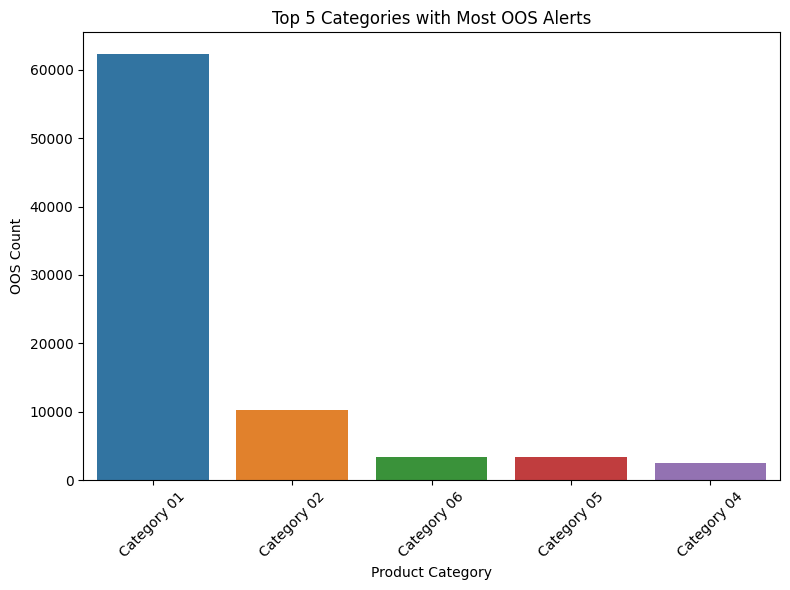

In [0]:
# Grouping OOS issues by product category
oos_count = safety_stock_df.groupBy("product_category").count().orderBy("count", ascending=False).limit(5).toPandas()

import matplotlib.pyplot as plt
import seaborn as sns
import os

# Ensure the directory exists
save_path = "/dbfs/FileStore/OSA_Project/"
os.makedirs(save_path, exist_ok=True)

# Plot the data
plt.figure(figsize=(8, 6))
sns.barplot(data=oos_count, x="product_category", y="count")
plt.title("Top 5 Categories with Most OOS Alerts")
plt.xlabel("Product Category")
plt.ylabel("OOS Count")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
plt.savefig(f"{save_path}top5_oos_categories.png")
plt.show()

##  Predicted vs Actual Sales 

In [0]:
# Join inventory and forecast tables to get actual sales (assuming total_sales_units contains actual sales)
joined_df = forecast_df.join(inventory_df, ["date", "store_id", "sku"], "inner")

# Select required columns for the graph
sales_data = joined_df.select("date", "predicted_sales_units", "total_sales_units").toPandas()

import plotly.express as px

# Create line graph using Plotly
fig = px.line(
    sales_data,
    x="date",
    y=["predicted_sales_units", "total_sales_units"],
    labels={"value": "Sales", "date": "Date"},
    title="Predicted vs Actual Sales by Date"
)

# Save as HTML
html_path = "/dbfs/FileStore/OSA_Project/predicted_vs_actual_sales.html"
fig.write_html(html_path)
fig.show()

print(f"HTML version saved at: {html_path}")


HTML version saved at: /dbfs/FileStore/OSA_Project/predicted_vs_actual_sales.html


In [0]:
# Convert date column to Pandas datetime
sales_data['date'] = pd.to_datetime(sales_data['date'])

# Group by month and calculate averages
monthly_sales = sales_data.groupby(sales_data['date'].dt.to_period("M")).mean().reset_index()

# Convert period to datetime for plotting
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()

# Create the plot
fig = px.line(
    monthly_sales,
    x="date",
    y=["predicted_sales_units", "total_sales_units"],
    labels={"value": "Sales", "date": "Month"},
    title="Predicted vs Actual Sales by Month"
)

# Save and show the plot
save_path = "/dbfs/FileStore/OSA_Project/predicted_vs_actual_monthly_sales.png"
fig.write_image(save_path)
fig.show()
print(f"Saved at: {save_path}")


/root/.ipykernel/905/command-3783069695819523-4188862947:5: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



Saved at: /dbfs/FileStore/OSA_Project/predicted_vs_actual_monthly_sales.png


##Lead Time Distribution

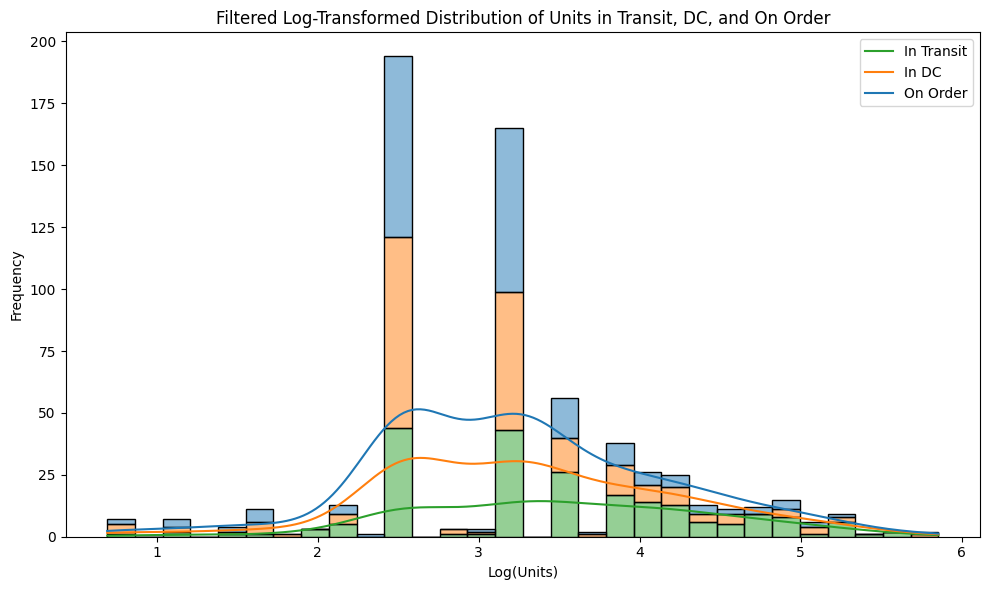

Combined plot saved at: /dbfs/FileStore/OSA_Project/filtered_log_units_distribution_combined.png


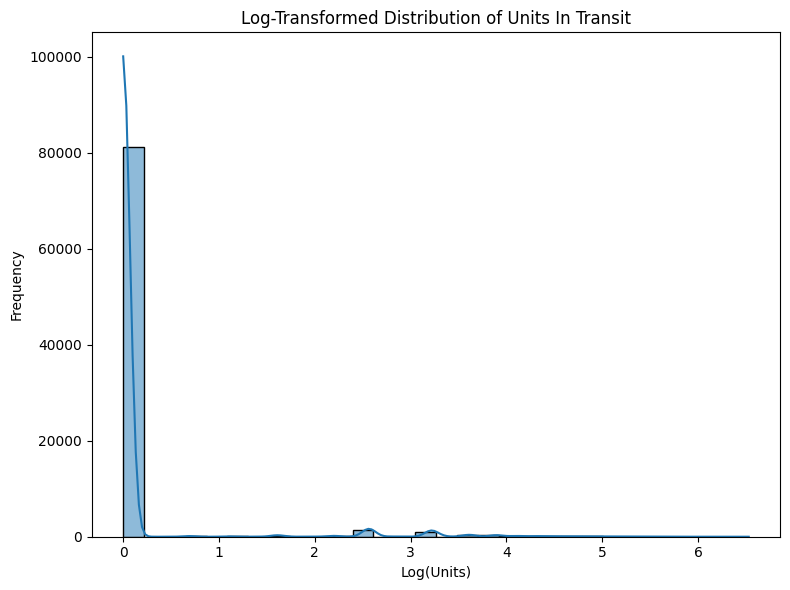

Individual plot for units_in_transit saved at: /dbfs/FileStore/OSA_Project/log_distribution_units_in_transit.png


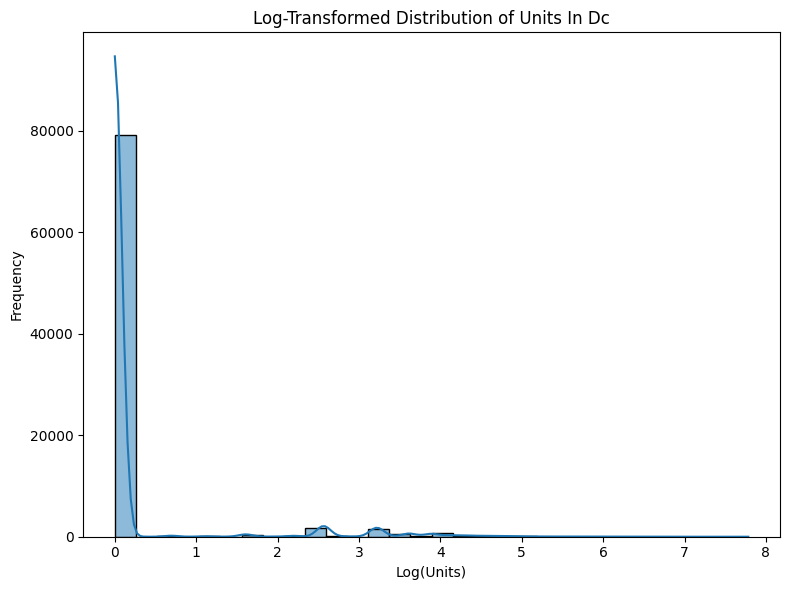

Individual plot for units_in_dc saved at: /dbfs/FileStore/OSA_Project/log_distribution_units_in_dc.png


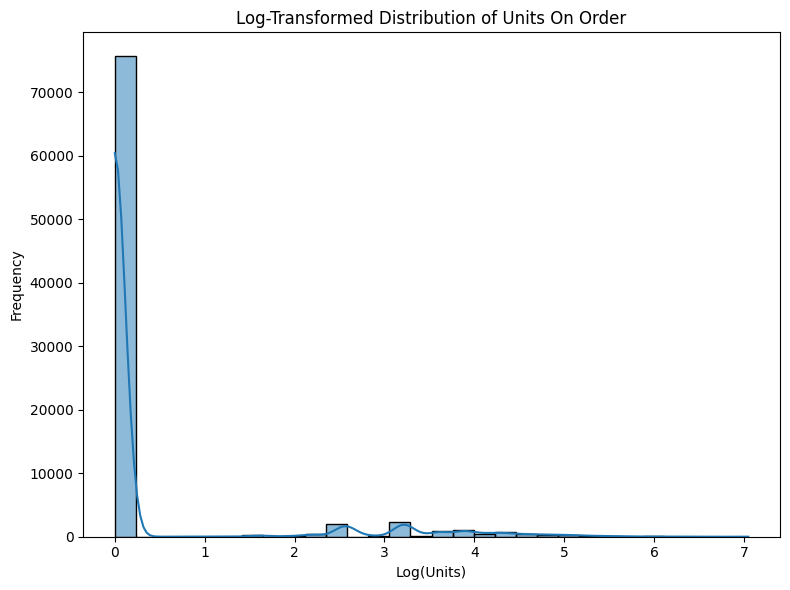

Individual plot for units_on_order saved at: /dbfs/FileStore/OSA_Project/log_distribution_units_on_order.png


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Adjusted: Filter and log-transform data
unit_data_log = unit_data.applymap(lambda x: np.log1p(x))  # Apply log transformation to avoid zero issues

# Filter to exclude extremely low or high log values
unit_data_filtered = unit_data_log[(unit_data_log > 0.1).all(axis=1) & (unit_data_log < 6).all(axis=1)]

# Combined Histogram: Filtered Log-Transformed Data
plt.figure(figsize=(10, 6))
sns.histplot(unit_data_filtered, bins=30, kde=True, multiple="stack")
plt.title("Filtered Log-Transformed Distribution of Units in Transit, DC, and On Order")
plt.xlabel("Log(Units)")
plt.ylabel("Frequency")
plt.legend(["In Transit", "In DC", "On Order"])
plt.tight_layout()

# Save the combined plot
save_path_combined = "/dbfs/FileStore/OSA_Project/filtered_log_units_distribution_combined.png"
plt.savefig(save_path_combined)
plt.show()
print(f"Combined plot saved at: {save_path_combined}")

# Separate Histograms: One for Each Column
columns = ['units_in_transit', 'units_in_dc', 'units_on_order']
for col in columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(np.log1p(unit_data[col]), bins=30, kde=True)
    plt.title(f"Log-Transformed Distribution of {col.replace('_', ' ').title()}")
    plt.xlabel("Log(Units)")
    plt.ylabel("Frequency")
    plt.tight_layout()

    # Save each plot
    save_path_individual = f"/dbfs/FileStore/OSA_Project/log_distribution_{col}.png"
    plt.savefig(save_path_individual)
    plt.show()
    print(f"Individual plot for {col} saved at: {save_path_individual}")


#### Pie Chart for Inventory Status Distribution

In [0]:
# Aggregate inventory status data
inventory_status_data = inventory_df.select(
    "on_hand_inventory_units", "replenishment_units", "units_in_dc", "units_on_order"
).toPandas()

# Calculate total counts for each status
status_totals = inventory_status_data.sum()

# Create a pie chart
import plotly.express as px
fig = px.pie(
    names=status_totals.index,
    values=status_totals.values,
    title="Inventory Status Distribution",
    labels={"names": "Inventory Status", "values": "Units"}
)

# Save the pie chart
save_path = "/dbfs/FileStore/OSA_Project/inventory_status_pie_chart.png"
fig.write_image(save_path)

# Display the interactive plot
fig.show()

print(f"Pie chart saved at: {save_path}")


Pie chart saved at: /dbfs/FileStore/OSA_Project/inventory_status_pie_chart.png


### OOS alerts across different product categories and inventory statuses

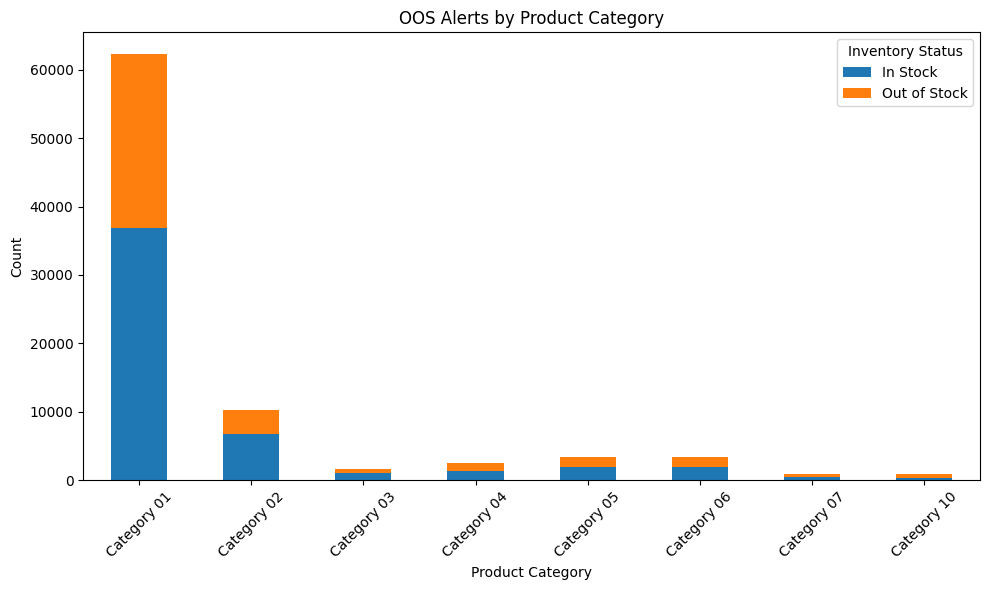

Stacked bar plot saved at: /dbfs/FileStore/OSA_Project/oos_by_category.png


In [0]:
# Add inventory status column
safety_stock_df = safety_stock_df.withColumn(
    "inventory_status",
    F.when(F.col("on_hand_inventory_units") > F.col("safety_stock"), "In Stock")
    .otherwise("Out of Stock")
)

# Group data by product category and inventory status
category_oos = safety_stock_df.groupBy("product_category", "inventory_status").count().toPandas()

# Pivot data for stacked bar plot
category_pivot = category_oos.pivot(index="product_category", columns="inventory_status", values="count").fillna(0)

# Create a stacked bar plot
import matplotlib.pyplot as plt
category_pivot.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("OOS Alerts by Product Category")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.legend(title="Inventory Status")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the plot
save_path = "/dbfs/FileStore/OSA_Project/oos_by_category.png"
plt.savefig(save_path)
plt.show()

print(f"Stacked bar plot saved at: {save_path}")



### Rolling Average Daily Sales

In [0]:
# Select and prepare data
daily_sales_data = safety_stock_df.select("date", "daily_sales_units").toPandas()

# Convert date column to datetime
daily_sales_data["date"] = pd.to_datetime(daily_sales_data["date"])

# Sort data by date
daily_sales_data = daily_sales_data.sort_values("date")

# Calculate 7-day rolling average
daily_sales_data["rolling_avg_sales"] = daily_sales_data["daily_sales_units"].rolling(window=7).mean()

# Create a line plot
import plotly.express as px
fig = px.line(
    daily_sales_data,
    x="date",
    y="rolling_avg_sales",
    title="7-Day Rolling Average of Daily Sales Over Time",
    labels={"rolling_avg_sales": "Rolling Avg Daily Sales", "date": "Date"}
)

# Save the plot
save_path = "/dbfs/FileStore/OSA_Project/rolling_avg_daily_sales.png"
fig.write_image(save_path)

# Display the interactive plot
fig.show()

print(f"Line chart saved at: {save_path}")


Line chart saved at: /dbfs/FileStore/OSA_Project/rolling_avg_daily_sales.png


### Total sales for each product category across different stores

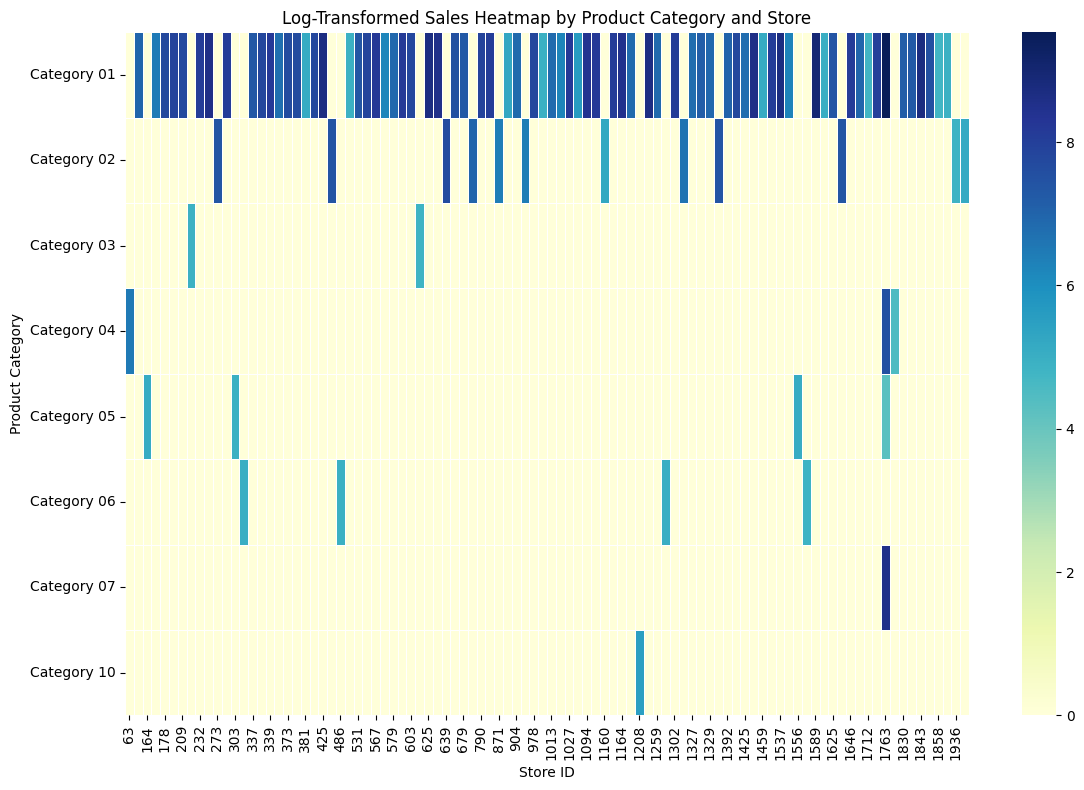

Log-transformed heatmap saved at: /dbfs/FileStore/OSA_Project/log_sales_heatmap.png


In [0]:
# Apply log transformation to sales data
heatmap_data_log = np.log1p(heatmap_data)

# Create heatmap with log-transformed data
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_data_log,
    cmap="YlGnBu",
    annot=False,
    fmt=".1f",
    linewidths=0.5
)
plt.title("Log-Transformed Sales Heatmap by Product Category and Store")
plt.xlabel("Store ID")
plt.ylabel("Product Category")
plt.tight_layout()

# Save the plot
save_path_log = "/dbfs/FileStore/OSA_Project/log_sales_heatmap.png"
plt.savefig(save_path_log)
plt.show()

print(f"Log-transformed heatmap saved at: {save_path_log}")



### Relationship between replenishment units and daily sales

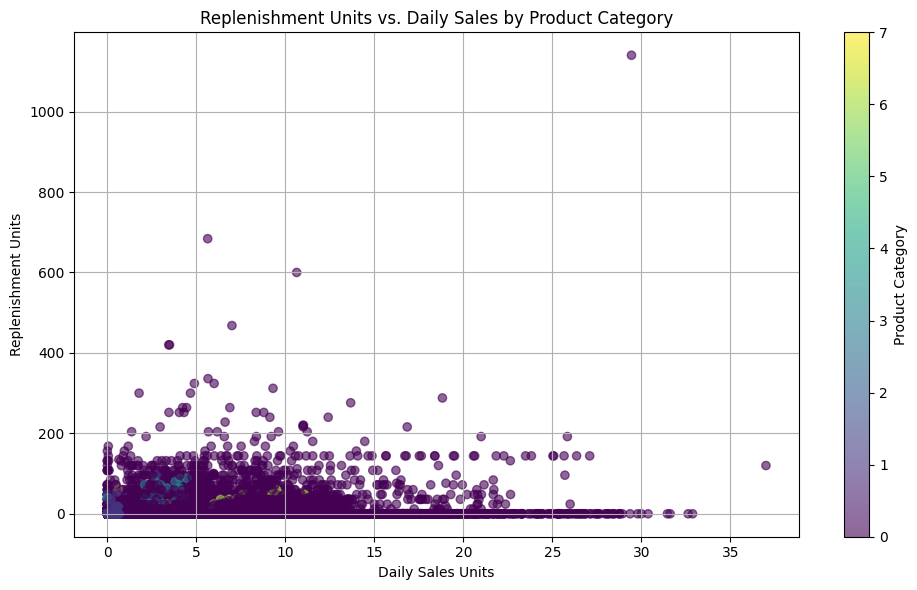

In [0]:
scatter_data["product_category"] = safety_stock_df.select("product_category").toPandas()
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    scatter_data["daily_sales_units"],
    scatter_data["replenishment_units"],
    alpha=0.6,
    c=scatter_data["product_category"].astype("category").cat.codes,
    cmap="viridis"
)
plt.colorbar(scatter, label="Product Category")
plt.title("Replenishment Units vs. Daily Sales by Product Category")
plt.xlabel("Daily Sales Units")
plt.ylabel("Replenishment Units")
plt.grid(True)
plt.tight_layout()
plt.show()



### Model Evaluation

In [0]:
# Join inventory_forecast with inventory_safety_stock to get actual sales (e.g., total_sales_units)
evaluation_df = forecast_df.join(
    safety_stock_df.select("date", "store_id", "sku", "total_sales_units"),
    on=["date", "store_id", "sku"],
    how="inner"
)

# Convert to Pandas for evaluation
evaluation_data = evaluation_df.select("predicted_sales_units", "total_sales_units").toPandas()

# Extract predictions and actuals
predictions = evaluation_data["predicted_sales_units"]
actuals = evaluation_data["total_sales_units"]

# Classification: Define OOS based on a threshold
oos_threshold = 5
actuals_class = (actuals <= oos_threshold).astype(int)  # Convert to binary
predictions_class = (predictions <= oos_threshold).astype(int)  # Convert to binary

# Import evaluation metrics
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score

# Mean Squared Error (MSE)
mse = mean_squared_error(actuals, predictions)

# Accuracy for classification
accuracy = accuracy_score(actuals_class, predictions_class)

# Precision for classification
precision = precision_score(actuals_class, predictions_class)

# Recall for classification
recall = recall_score(actuals_class, predictions_class)

# Display results
print("Evaluation Metrics:")
print("Mean Squared Error (MSE):", mse)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)



Evaluation Metrics:
Mean Squared Error (MSE): 68.70368852459016
Accuracy: 0.8316042154566745
Precision: 0.8995649861586505
Recall: 0.9038667068592255


In [0]:
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import ttest_rel
import pandas as pd

# Step 1: Load SES predictions and actual sales data
inventory_forecast = spark.table("osa.inventory_forecast")
inventory_actual = spark.table("osa.inventory")

# Combine SES predictions and actual sales into a single DataFrame
data = (
    inventory_forecast
    .join(inventory_actual, on=["date", "store_id", "sku"], how="inner")
    .selectExpr("date", "store_id", "sku", "predicted_sales_units as ses_predictions", "total_sales_units as actual_sales")
    .toPandas()
)

# Ensure the 'date' column is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Step 2: Group data by store and SKU to handle duplicates
results = []

for (store_id, sku), group in data.groupby(['store_id', 'sku']):
    group = group.sort_values(by="date").set_index("date")  # Ensure the data is sorted by date

    # Check if there are enough data points for ARIMA
    if group['actual_sales'].isna().sum() == 0 and len(group) > 3:  # Minimum data points for ARIMA
        try:
            # Fit ARIMA model
            arima_model = ARIMA(group['actual_sales'], order=(1, 1, 1))  # Adjust ARIMA order as needed
            arima_results = arima_model.fit()

            # Predict using ARIMA for the same period as SES
            group['arima_predictions'] = arima_results.predict(start=group.index.min(), end=group.index.max(), dynamic=False)
            results.append(group)
        except Exception as e:
            print(f"ARIMA failed for Store {store_id}, SKU {sku}: {e}")
    else:
        print(f"Insufficient data for Store {store_id}, SKU {sku}")

# Combine results back into a single DataFrame
if results:
    final_data = pd.concat(results)
else:
    raise ValueError("No valid data for ARIMA modeling.")

# Step 3: Conduct Paired T-Test between SES and ARIMA predictions
t_stat, p_value = ttest_rel(final_data['ses_predictions'], final_data['arima_predictions'])

# Step 4: Output Results
print(f"T-Statistic: {t_stat}")
print(f"P-Value: {p_value}")

if p_value < 0.05:
    print("Reject the null hypothesis: ARIMA shows a significant difference in performance compared to SES.")
else:
    print("Fail to reject the null hypothesis: No significant difference between ARIMA and SES.")


/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D w

T-Statistic: 0.2123695856990592
P-Value: 0.8318192185477211
Fail to reject the null hypothesis: No significant difference between ARIMA and SES.
